In [2]:
library(Giotto)

In [4]:
expr_path = system.file("extdata", "visium_DG_expr.txt", package = 'Giotto')
loc_path = system.file("extdata", "visium_DG_locs.txt", package = 'Giotto')
mini_visium <- createGiottoObject(raw_exprs = expr_path,
                                   spatial_locs = loc_path)

Consider to install these (optional) packages to run all possible Giotto commands:  tiff biomaRt trendsceek multinet RTriangle FactoMiner
 Giotto does not automatically install all these packages as they are not absolutely required and this reduces the number of dependencies 


Warning message in createGiottoObject(raw_exprs = expr_path, spatial_locs = loc_path):
“raw_exprs argument is deprecated, use expression argument in the future 
”


List of 1
 $ raw: chr "/Library/Frameworks/R.framework/Versions/4.0/Resources/library/Giotto/extdata/visium_DG_expr.txt"
NULL


Depth of provided expression list is 1, working with one type of molecular feature 





 no external python path was provided, but a giotto python environment was found and will be used 


In [6]:
# read image
png_path = system.file("extdata", "deg_image.png", package = 'Giotto')
mg_img = magick::image_read(png_path)

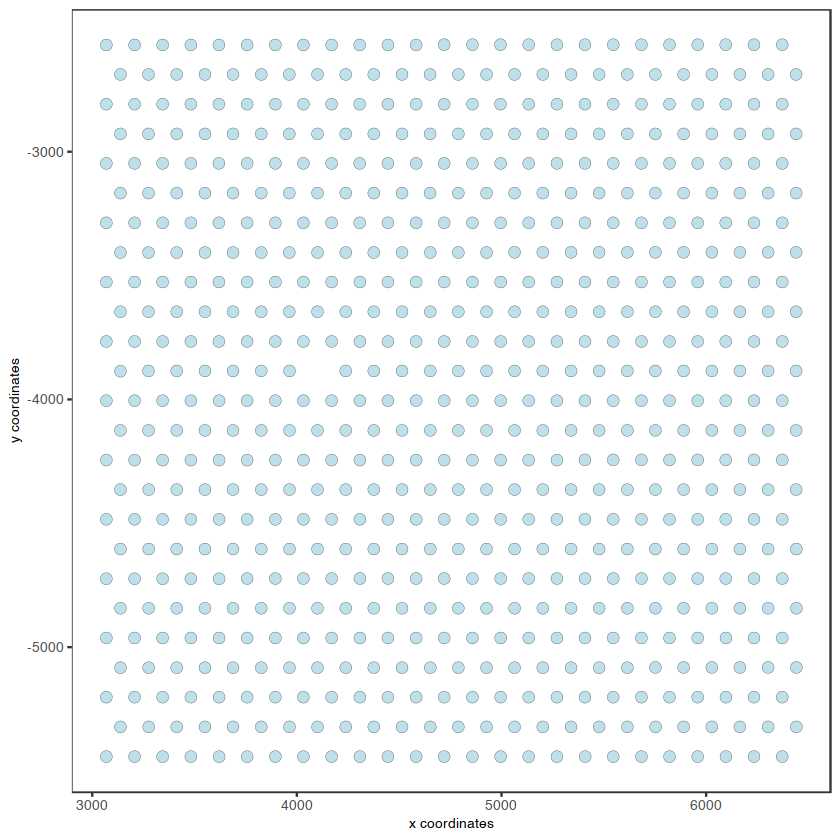

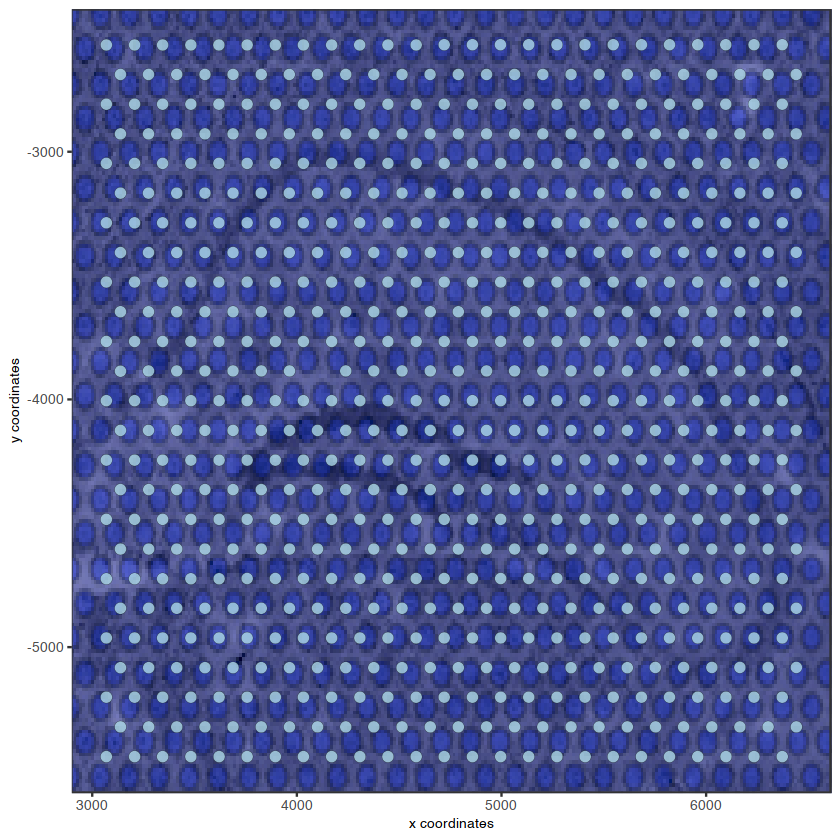

In [7]:
# test and modify image alignment
mypl = spatPlot(mini_visium, return_plot = T, point_alpha = 0.8)
orig_png = createGiottoImage(gobject = mini_visium, mg_object = mg_img, name = 'image',
                             xmax_adj = 450, xmin_adj = 550,
                             ymax_adj = 200, ymin_adj = 200)
mypl_image = addGiottoImageToSpatPlot(mypl, orig_png)
mypl_image


In [8]:
# add image to Giotto object

image_list = list(orig_png)
mini_visium = addGiottoImage(gobject = mini_visium,
                             images = image_list)
showGiottoImageNames(mini_visium)

The following images are available:  image 


[1] "image"